# Time-Lapse Movie
This notebook shows how to make a time-lapse animation from a set of CamHD videos. This notebook relies on the scene log compiled by Friedrich Knuth and Hailey Conrad.

#### Setup your environment

In [1]:
import pycamhd.lazycache as camhd
repo = camhd.lazycache()

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

#### Ingest the Rutgers scene log into a nested list

In [2]:
import requests
import csv
scene_log_url = 'https://raw.githubusercontent.com/ooi-data-review/camhd_metadata/master/scene_timing/zoom0_scenes.csv'
scene_log_page = requests.get(scene_log_url)
scene_log_content = scene_log_page.content.decode('utf-8')
scene_log_csv = csv.reader(scene_log_content.splitlines(), delimiter=',')
scene_log = list(scene_log_csv)

#### Get a list of local CamHD files to process

In [3]:
## Get list of CamHD files
cache_root = '/RS03ASHS/PN03B/06-CAMHDA301/'

paths = [ '2015/11/25']

#paths = [ '2015/11/', '2015/12/']

file_urls = []
for p in paths:
    file_urls += repo.find( cache_root + p )
 
print(file_urls)   

Querying  https://camhd-app-dev.appspot.com/v1/org/oceanobservatories/rawdata/files/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25
['/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T000000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T030000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T060000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T090000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T120000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T150000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T180000Z.mov', '/RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T210000Z.mov']


#### Get a list of frame numbers to process using the log file

In [4]:
import os
import re

good_movies = []
frame_numbers = []
for url in file_urls:
    foo,mov_file = os.path.split( url )
    print(mov_file)
    
    for row in scene_log:
         if re.match( row[0], mov_file ):
            
            next_frame_time = row[3].split(':') # this is the third scene
            
            if len(next_frame_time)==3:
                frame_time = next_frame_time
                
                good_movies.append( url )
                frame_numbers.append(int(round((int(frame_time[1])*60+int(frame_time[2]))*29.95))+60)
                
print( "Found %d good movies" % len(good_movies) )

CAMHDA301-20151125T000000Z.mov
CAMHDA301-20151125T030000Z.mov
CAMHDA301-20151125T060000Z.mov
CAMHDA301-20151125T090000Z.mov
CAMHDA301-20151125T120000Z.mov
CAMHDA301-20151125T150000Z.mov
CAMHDA301-20151125T180000Z.mov
CAMHDA301-20151125T210000Z.mov
Found 8 good movies


#### Show the first image of the time-lapse and save it for the cover image

In [5]:
import requests
from PIL import Image
from io import BytesIO

def get_frame( url, frame ):
    r = requests.get( (url + "/frame/%d") % frame )
    return Image.open( BytesIO( r.content ) )

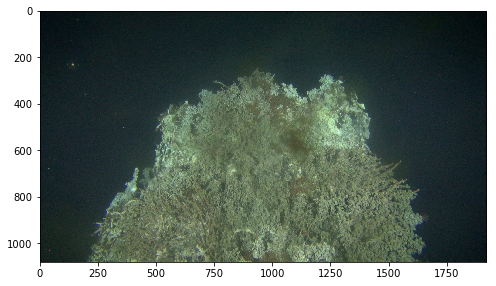

In [6]:
plt.rc('figure', figsize=(8, 8))

frame = repo.get_frame(good_movies[0], frame_numbers[0] )
imgplot = plt.imshow(frame)

In [7]:
from scipy.misc import imresize
resized = imresize(frame, (270, 480))
Image.fromarray(resized).save('time_lapse.png')

#### Loop through the file list to generate an MP4 using an FFMPEG pipe

In [8]:
%%time
import subprocess as sp
command = [ 'ffmpeg',
           '-y', #overwrite output file if it exists
           '-f', 'rawvideo',
           '-vcodec','rawvideo',
           '-s', '1920x1080', # size of input frame
           '-pix_fmt', 'rgb24',
           '-r', '30', # output frame rate
           '-i', '-', # input from pipe
           '-an', # no audio
           '-vf', 'scale=480x270',
           '-c:v', 'h264',
           '-preset', 'veryfast',
           '-crf', '18',
           '-pix_fmt', 'yuv420p',
           'time_lapse.mp4' ]

pipe = sp.Popen(command, stdin=sp.PIPE, stderr=sp.PIPE)

for i, filename in enumerate(good_movies):
    print( i, filename )
    frame = repo.get_frame(filename, frame_numbers[i])
    pipe.stdin.write(frame.tobytes())

pipe.stdin.flush() # Ensure nothing is left in the buffer
pipe.terminate()

0 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T000000Z.mov
1 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T030000Z.mov
2 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T060000Z.mov
3 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T090000Z.mov
4 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T120000Z.mov
5 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T150000Z.mov
6 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T180000Z.mov
7 /RS03ASHS/PN03B/06-CAMHDA301/2015/11/25/CAMHDA301-20151125T210000Z.mov
CPU times: user 1.76 s, sys: 279 ms, total: 2.04 s
Wall time: 6.8 s


#### Show the video using HTML5 magic

In [9]:
%%HTML
<video width="480" height="270" controls poster="time_lapse.png">
  <source src="time_lapse.mp4" type="video/mp4">
</video>

### References

PyCamHD: https://github.com/tjcrone/pycamhd<br>
CamHDHub: https://github.com/tjcrone/camhdhub<br>
Raw Data Archive: https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/<br>
CamHD Metadata: https://github.com/ooi-data-review/camhd_metadata